# Эмбеддинг на базе Bert Transformer

BERT (Bidirectional Encoder Representations from Transformers) - одна из наиболее известных и успешных моделей обработки естественного языка, основанная на архитектуре Трансформер.

In [1]:
# Зависимые от задачи параметры, которые нецелесообразно выносить в конфиг
TASK_NAME = "Bert Classifier"
# BERT_MODEL_FILENAME = "clm_bert_model.pkl"

In [2]:
# Загружаем переменные среды с секретами для ClearML
from dotenv import load_dotenv

load_dotenv()

True

Загружаем параметры из файла конфигурации

In [3]:
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

GlobalHydra.instance().clear()

# Hydra context initialization
initialize(version_base=None, config_path=".", job_name="tf-idf-classifier")
cfg = compose(config_name="config")

#print(OmegaConf.to_yaml(cfg))

Инициируем трекинг в CLearML

In [4]:
from clearml import Dataset, Task

# Инициируем трекинг в CLearML
task = Task.init(
    project_name=cfg.project.name, 
    task_name=TASK_NAME, 
    output_uri=True
)

# Подготовка локальной копии датасета
dataset_path = Dataset.get(
    dataset_project=cfg.dataset.project,
    dataset_name=cfg.dataset.name, 
).get_local_copy()

task.set_progress(0)

ClearML Task: created new task id=45554c2750e54c0bb5fd93f6ed64ffa7
2024-05-19 13:40:54,986 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/632d87a87e714a7fbc73c21e83eebfa5/experiments/45554c2750e54c0bb5fd93f6ed64ffa7/output/log
2024-05-19 13:40:55,594 - clearml - INFO - Dataset.get() did not specify alias. Dataset information will not be automatically logged in ClearML Server.


Загружаем датасет

In [5]:
import os
import polars as pl

data = pl.read_csv(
    os.path.join(dataset_path, cfg.dataset.file),
    has_header=False,
    new_columns=["Polarity", "Title", "Review"],
    n_rows=cfg.params.nrows,
)

pl.Config.set_fmt_str_lengths(100)
data.head(3)

shape: (3, 3)
┌──────────┬───────────────────────────────────────┬───────────────────────────────────────────────┐
│ Polarity ┆ Title                                 ┆ Review                                        │
│ ---      ┆ ---                                   ┆ ---                                           │
│ i64      ┆ str                                   ┆ str                                           │
╞══════════╪═══════════════════════════════════════╪═══════════════════════════════════════════════╡
│ 2        ┆ Stuning even for the non-gamer        ┆ This sound track was beautiful! It paints the │
│          ┆                                       ┆ senery in your mind so well I would recomend  │
│          ┆                                       ┆ it even t…                                    │
│ 2        ┆ The best soundtrack ever to anything. ┆ I'm reading a lot of reviews saying that this │
│          ┆                                       ┆ is the best 'game soundtrack' and I figured   │
│          ┆                                       ┆ that I'd w…                                   │
│ 2        ┆ Amazing!                              ┆ This soundtrack is my favorite music of all   │
│          ┆                                       ┆ time, hands down. The intense sadness of      │
│          ┆                                       ┆ "Prisoners of F…                              │
└──────────┴───────────────────────────────────────┴───────────────────────────────────────────────┘

In [6]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(10)

Проверяем, что датасет сбалансирован по отзывам

In [7]:
data = data.select('Polarity', 'Review').with_columns(
    pl.col("Polarity").map_elements(
        lambda polarity: "Negative" if polarity == 1 else "Positive"
    )
)

data['Polarity'].value_counts()

/tmp/ipykernel_1833/3547166247.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  data = data.select('Polarity', 'Review').with_columns(


shape: (2, 2)
┌──────────┬───────┐
│ Polarity ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ Negative ┆ 24494 │
│ Positive ┆ 25506 │
└──────────┴───────┘

Разбиваем на тренировочную и тестовую выборки

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    data,
    test_size=cfg.params.test_size,
    shuffle=cfg.params.shuffle,
    random_state=cfg.params.random_state,
)


Загружаем Bert модель и его токенайзер

In [9]:
import torch
from transformers import AutoModel, AutoTokenizer

model_name = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# Проверим наличие графического процессора
device

device(type='cuda')

Загружаем батчами во избежание переполнения памяти

In [11]:
from torch.utils.data import DataLoader

fixed_batch_size = 128
train_dataloader = DataLoader(
    train["Review"].to_list(), batch_size=fixed_batch_size, shuffle=False
)
test_dataloader = DataLoader(
    test["Review"].to_list(), batch_size=fixed_batch_size, shuffle=False
)

In [12]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(20)

[GPU] Инференс получаем как выход с последнего слоя Bert

In [13]:
def batch_inference(batch):
    tokenized_batch = tokenizer(
        batch, padding=True, truncation=True, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        hidden_batch = bert_model(**tokenized_batch)
        batch_embeddings = hidden_batch.last_hidden_state[:, 0, :].detach().to("cpu")
        return batch_embeddings

train_embeddings = torch.concat(
    [batch_inference(batch_data) for batch_data in train_dataloader]
)
test_embeddings = torch.concat(
    [batch_inference(batch_data) for batch_data in test_dataloader]
)

ClearML results page: https://app.clear.ml/projects/632d87a87e714a7fbc73c21e83eebfa5/experiments/45554c2750e54c0bb5fd93f6ed64ffa7/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [14]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(85)

# Фиксируем артефакты в ClearML
task.upload_artifact(
    name="train_embeddings",
    artifact_object=train_embeddings,
)

task.upload_artifact(
    name="test_embeddings",
    artifact_object=test_embeddings,
)

True

Обучаем на этих эмбеддингах логистическую регрессию:

In [15]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model_params = {
    "random_state": cfg.params.random_state,
    "multi_class": "multinomial",
    "solver": "saga",
}

task.connect(model_params)

model_lr = LogisticRegression(**model_params)

model_lr.fit(train_embeddings, train["Polarity"])

LogisticRegression(multi_class='multinomial', random_state=42, solver='saga')

In [16]:
import pickle

# Фиксируем прогресс выполнения в CLearML
task.set_progress(80)

# Фиксируем артефакты в ClearML
task.upload_artifact(
    name='LogisticRegression',
    artifact_object=pickle.dumps(model_lr)
)

True

Получаем предсказание модели

In [17]:
predicts = model_lr.predict(test_embeddings)

report = classification_report(test["Polarity"], predicts, output_dict=True)

# Формируем confusion matrix на два класса
conf_matrix = confusion_matrix(test["Polarity"], predicts)

In [18]:
# Фиксируем прогресс выполнения в CLearML
task.set_progress(95)

# Фиксируем параметры модели
logger = task.get_logger()

logger.report_single_value("Accuracy", report.pop("accuracy"))

for class_name, metrics in report.items():
    for metric, value in metrics.items():
        logger.report_single_value(f"{class_name}_{metric}", value)

logger.report_confusion_matrix("Confusion matrix", "ignored", matrix=conf_matrix)

In [19]:
# Завершение эксперимента - обязательно!
task.close()

Контрольная визуализация матрицы

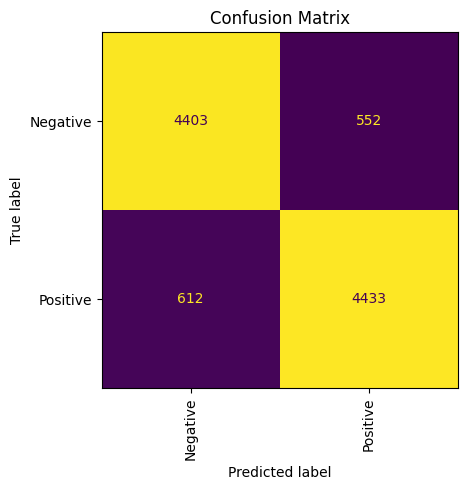

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(test["Polarity"], predicts, ax=ax, colorbar=False)
ax.xaxis.set_tick_params(rotation=90)
_ = ax.set_title("Confusion Matrix")
plt.tight_layout()